Why does Tokyo have low review scores in the "location" category?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
city_names = ["tokyo", "sydney", "melbourne", "singapore", "hongkong", "taipei", "bangkok"]

In [3]:
cities_df = dict()
for city in city_names:
    cities_df[city] = pd.read_csv("./data/listings_{c}.csv".format(c=city))

In [4]:
reviews_df = dict()
for city in city_names:
    reviews_df[city] = pd.read_csv("./data/reviews_{c}.csv".format(c=city))

In [5]:
df_full_tokyo = pd.merge(cities_df["tokyo"], reviews_df["tokyo"], left_on='id', right_on='listing_id')

df_full_tokyo['all_reviews'] = df_full_tokyo.apply(lambda row: f"Score: {row['review_scores_location']}<br>Review: {row['comments']}", axis=1)

# This step concatenates all reviews and scores for each listing into a single string.
df_full_tokyo['all_reviews'] = df_full_tokyo.groupby('listing_id')['all_reviews'].transform(lambda x: '<br><br>'.join(x))

# Drop duplicate listings, keeping only the first entry (which now contains all reviews and scores)
df_full = df_full_tokyo.drop_duplicates(subset='listing_id')


## Plotting the location in a geographical map

Plotting the location of listings that have top 85% review scores and bottom 10% review scores

In [7]:
import folium

tokyo_coords = [35.682839, 139.759455]

m = folium.Map(location=tokyo_coords, zoom_start=12)


quantile_25 = df_full['review_scores_location'].quantile(0.10) # Too many reviews below 5%, so we use 3% quantile
quantile_75 = df_full['review_scores_location'].quantile(0.85) # No reviews above 90%, so we use 85% quantile

# Plot each point on the map
for idx, row in df_full.iterrows():
    if row['review_scores_location'] < quantile_25:
        color = 'blue'
    elif row['review_scores_location'] > quantile_75:
        color = 'green'
    else:
        continue

    marker = folium.CircleMarker(location=[row['latitude'], row['longitude']],
                                 radius=5,
                                 color=color,
                                 fill=True,
                                 fill_color=color,
                                 fill_opacity=0.6)

    marker.add_child(folium.Popup(row['all_reviews'], max_width=300))  # adjust max_width to your preference
    marker.add_to(m)

m.save('./map/bad_and_good_location_{c}.html'.format(c="tokyo"))
print("Map saved to 'bad_and_good_location_tokyo.html'. Open it in your browser to view the map.")

Map saved to 'bad_and_good_location_tokyo.html'. Open it in your browser to view the map.


Plot all the location of listings in Tokyo.
Red color for scores above the median, blue color for scores below the median.

In [9]:
import numpy as np

df_sampled = df_full.copy()

quantile_50 = df_sampled['review_scores_location'].quantile(0.50)

m = folium.Map(location=[35.6895, 139.6917], zoom_start=12)

df_sampled['deviation'] = df_sampled['review_scores_location'] - quantile_50

def determine_color(deviation):
    if deviation is None or np.isnan(deviation):
        return "#ffffff"
    # Use logarithmic scaling to emphasize the deviation
    scaled_deviation = np.sign(deviation) * np.log1p(abs(deviation))

    if scaled_deviation > 0:
        # Red color for scores above the median
        intensity = int(255 * (1 - scaled_deviation))
        return f"#{255:02x}{intensity:02x}{intensity:02x}"
    else:
        # Blue color for scores below the median
        intensity = int(255 * (1 + scaled_deviation))
        return f"#{intensity:02x}{intensity:02x}ff"


# Plot each point on the map using the sampled dataframe
for idx, row in df_sampled.iterrows():
    color = determine_color(row['deviation'])
    marker = folium.CircleMarker(location=[row['latitude'], row['longitude']],
                                 radius=5,
                                 color=color,
                                 fill=True,
                                 fill_color=color,
                                 fill_opacity=0.6)
    marker.add_to(m)

m.save('./map/location_scores_heatmap_tokyo_sampled.html')
print("Map saved to 'location_scores_heatmap_tokyo_sampled.html'. Open it in your browser to view the map.")


Map saved to 'location_scores_heatmap_tokyo_sampled.html'. Open it in your browser to view the map.


In [99]:
tokyo_coords = [35.682839, 139.759455]

m = folium.Map(location=tokyo_coords, zoom_start=12)


quantile_25 = df_full['review_scores_location'].quantile(0.20) # Too many reviews below 20%, so we use 3% quantile
quantile_75 = df_full['review_scores_location'].quantile(0.80) # No reviews above 90%, so we use 85% quantile

# Plot each point on the map
for idx, row in df_full.iterrows():
    if row['review_scores_location'] < quantile_25:
        color = 'blue'
    elif row['review_scores_location'] > quantile_75:
        color = 'green'
    else:
        continue

    marker = folium.CircleMarker(location=[row['latitude'], row['longitude']],
                                 radius=5,
                                 color=color,
                                 fill=True,
                                 fill_color=color,
                                 fill_opacity=0.6)

    marker.add_child(folium.Popup(row['all_reviews'], max_width=300))  # adjust max_width to your preference
    marker.add_to(m)

m.save('./map/bad_and_good_location_{c}_with_comments.html'.format(c="tokyo"))
print("Map saved to 'bad_and_good_location_tokyo_with_comments.html'. Open it in your browser to view the map.")

Map saved to 'bad_and_good_location_tokyo_with_comments.html'. Open it in your browser to view the map.


### Relation between location and neighbourhood

I created a table of average location scores for each neighbourhood.
The table is sorted by the average location score.

It seems that the neighbourhoods with the highest average location can be classified into to groups:
1. Those located in nature, far from the city center. For example, "Fussa Shi" and "Ome Shi" are located in the mountains.
2. Those located in luxury areas. For example, "Minato Ku", "Chiyoda Ku", "Chuo Ku" are business districts, and "Setagaya Ku" is a residential area with many expensive houses.

The neighbourhoods with the lowest average location score are mostly located in residential but not the best nature areas.

In [13]:
neighbourhood_scores = df_full_tokyo.groupby('neighbourhood_cleansed')['review_scores_location'].mean()

neighbourhood_scores_sorted = neighbourhood_scores.reset_index().sort_values('review_scores_location', ascending=False)
neighbourhood_scores_sorted.reset_index(drop=True, inplace=True)

print("Top 10 neighbourhoods with the highest average location score:")
print(neighbourhood_scores_sorted.head(10))

print("\nBottom 10 neighbourhoods with the lowest average location score:")
print(neighbourhood_scores_sorted.tail(10).sort_values('review_scores_location', ascending=True))

Top 10 neighbourhoods with the highest average location score:
  neighbourhood_cleansed  review_scores_location
0              Fussa Shi                4.966265
1              Minato Ku                4.809081
2                Ome Shi                4.795043
3            Setagaya Ku                4.777035
4             Chiyoda Ku                4.776826
5              Chofu Shi                4.756662
6            Koganei Shi                4.754881
7             Shibuya Ku                4.749732
8                Chuo Ku                4.744929
9            Shinjuku Ku                4.744700

Bottom 10 neighbourhoods with the lowest average location score:
   neighbourhood_cleansed  review_scores_location
46          Tachikawa Shi                4.146311
45    Musashimurayama Shi                4.239318
44               Hino Shi                4.286992
43              Inagi Shi                4.330000
42             Hamura Shi                4.380460
41            Akiruno Shi       

To find relation between location review scores and neighbourhoods, I conducted Kruskal-Wallis test for each neighbourhood and property type.

The reason I used Kruskal-Wallis test instead of ANOVA is that the location review scores are not normally distributed.
The null hypothesis is that there is no difference in location review scores between neighbourhoods/property type.

The extremely low p-values in both suggest that the differences in location scores between neighbourhoods are not due to random chance.

In [24]:
from scipy.stats import kruskal

data_arrays = [df_full['review_scores_location'][df_full['neighbourhood_cleansed'] == neighbourhood].dropna().values for neighbourhood in df_full['neighbourhood_cleansed'].unique()]

# Conduct the Kruskal-Wallis H test
stat, p = kruskal(*data_arrays)

print(f"Kruskal-Wallis H statistic: {stat: .10f}")
print(f"P-value: {p :.10f}")


Kruskal-Wallis H statistic:  340.4728430923
P-value: 0.0000000000


## Relation between location and public transportation

In [25]:
# Read external data about train stations in Japan
# Data available at: https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N02-v2_3.html
import geopandas as gpd

gdf = gpd.read_file('data/N02-20_Station.geojson')

In [27]:
# Read data

def extract_coords(geom):
    if geom.geom_type == 'MultiLineString':
        return geom.geoms[0].coords[0]  # Get the first line segment's first coordinate
    else:
        return geom.coords[0]  # For simple LineString geometries

# Convert GeoJSON to DataFrame
stations_df = pd.DataFrame({
    'station_name': gdf['N02_005'],
    'longitude': gdf['geometry'].apply(lambda geom: extract_coords(geom)[0]),
    'latitude': gdf['geometry'].apply(lambda geom: extract_coords(geom)[1]),
    'train_line': gdf['N02_003']
})

# Haversine formula to calculate distance
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Find nearest station for each listing
nearest_stations = []
distances = []
train_lines = []

for idx, row in df_full.iterrows():
    distances_to_stations = stations_df.apply(lambda station: haversine(row['longitude'], row['latitude'], station['longitude'], station['latitude']), axis=1)
    min_distance_idx = distances_to_stations.idxmin()
    nearest_stations.append(stations_df.iloc[min_distance_idx]['station_name'])
    distances.append(distances_to_stations[min_distance_idx])
    train_lines.append(stations_df.iloc[min_distance_idx]['train_line'])

# Update DataFrame
df_full['nearest_station'] = nearest_stations
df_full['distance_to_station'] = distances
df_full['train_line'] = train_lines

# Save to CSV
df_full.to_csv('./listings_tokyo_full.csv', index=False)

/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3931326242.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['nearest_station'] = nearest_stations
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3931326242.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['distance_to_station'] = distances
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3931326242.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

### Relation between location and distance to nearest station

I calculated the correlation coefficient between location review scores and distance to nearest station.
The correlation coefficient is -0.21, which suggests that there is a weak negative correlation between the two variables.
This means that listings that are further away from the nearest station tend to have slightly higher location review scores, which is counter-intuitive. However, the strength of this relationship is not very strong, so while proximity to a station is a factor, there are likely other significant factors influencing location review scores.

Correlation between distance to nearest station and location review scores: -0.21


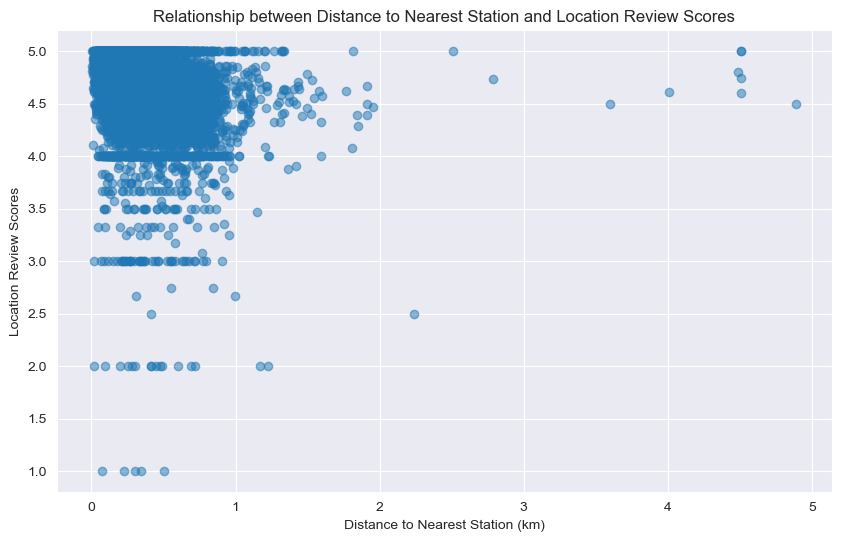

In [31]:
correlation = df_full['distance_to_station'].corr(df_full['review_scores_location'])
print(f"Correlation between distance to nearest station and location review scores: {correlation:.2f}")


plt.figure(figsize=(10, 6))
plt.scatter(df_full['distance_to_station'], df_full['review_scores_location'], alpha=0.5)
plt.title('Relationship between Distance to Nearest Station and Location Review Scores')
plt.xlabel('Distance to Nearest Station (km)')
plt.ylabel('Location Review Scores')
plt.grid(True)
plt.show()


The confidence interval does not contain 0, which means the negative correlation between distance to the nearest station and location review scores is statistically significant at the 95% confidence level.
Also, the interval is relatively narrow, which suggests a pretty high level of confidence in the correlation coefficient.

In [36]:
# Calculating the confidence interval for the correlation coefficient using Fisher's Z transformation
def get_confidence_interval(df):
    r = -0.25
    n = len(df)

    # Fisher's Z Transformation
    z = 0.5 * np.log((1 + r) / (1 - r))

    # Standard error of z
    SE_z = 1/np.sqrt(n-3)

    # 95% CI for z
    z_alpha_2 = 1.96  # for 95% CI
    z_lower = z - z_alpha_2 * SE_z
    z_upper = z + z_alpha_2 * SE_z

    # Transform z CI back to r
    r_lower = (np.exp(2*z_lower) - 1) / (np.exp(2*z_lower) + 1)
    r_upper = (np.exp(2*z_upper) - 1) / (np.exp(2*z_upper) + 1)

    print(f"95% Confidence Interval for the correlation coefficient: ({r_lower:.3f}, {r_upper:.3f})")

get_confidence_interval(df_full['distance_to_station'])

95% Confidence Interval for the correlation coefficient: (-0.268, -0.232)


#### Calculate correlation coefficient for "Shi" and "Ku" separately

I calculated the correlation coefficient between location review score and distancet to the nearest station, separately for "Shi" and "Ku" to see if there is a difference between the two.
The correlation coefficient for "Shi" is -0.06, and the correlation coefficient for "Ku" is -0.24, which suggests that there is a stronger negative correlation. However, the number of listings in "Shi" is much smaller than the number of listings in "Ku", so the correlation coefficient for "Shi" is less reliable.

In [45]:
def calculate_correlation_for_area(df, area_type):
    df = df[df['neighbourhood_cleansed'].notna()]

    filtered_df = df[df['neighbourhood_cleansed'].str.endswith(area_type)]

    # Calculate the correlation coefficient
    correlation = filtered_df['distance_to_station'].corr(filtered_df['review_scores_location'])

    return correlation

# Calculate correlation for "Shi"
shi_correlation = calculate_correlation_for_area(df_full, "Shi")
print(f"Correlation for 'Shi' areas: {shi_correlation:.2f}")

# Calculate correlation for "Ku"
ku_correlation = calculate_correlation_for_area(df_full, "Ku")
print(f"Correlation for 'Ku' areas: {ku_correlation:.2f}")


Correlation for 'Shi' areas: -0.06
Correlation for 'Ku' areas: -0.24


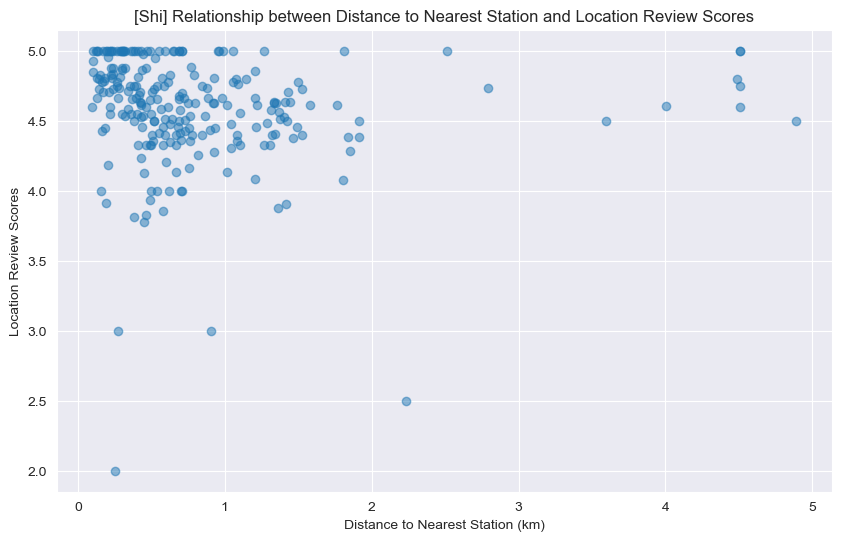

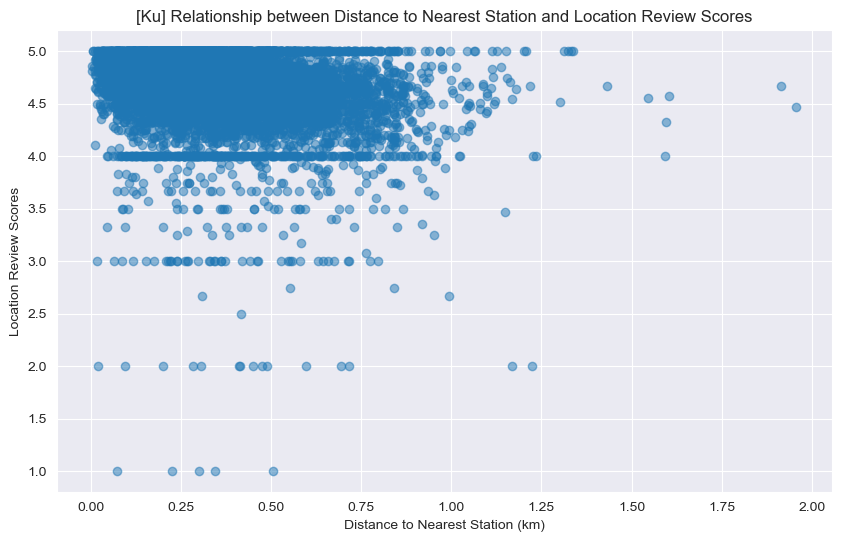

In [47]:
def scatter_plot(df, area_type):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['distance_to_station'], df['review_scores_location'], alpha=0.5)
    plt.title(f'[{area_type}] Relationship between Distance to Nearest Station and Location Review Scores'.format(area_type=area_type))
    plt.xlabel('Distance to Nearest Station (km)')
    plt.ylabel('Location Review Scores')
    plt.grid(True)
    plt.show()

# Scatter plot for "Shi"
shi_df = df_full[df_full['neighbourhood_cleansed'].str.endswith("Shi")]
scatter_plot(shi_df, "Shi")

# Scatter plot for "Ku"
shi_df = df_full[df_full['neighbourhood_cleansed'].str.endswith("Ku")]
scatter_plot(shi_df, "Ku")

### Relation between location and train line

/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3488250533.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = df_full.groupby('train_line').median()['review_scores_location'].sort_values(ascending=False).index


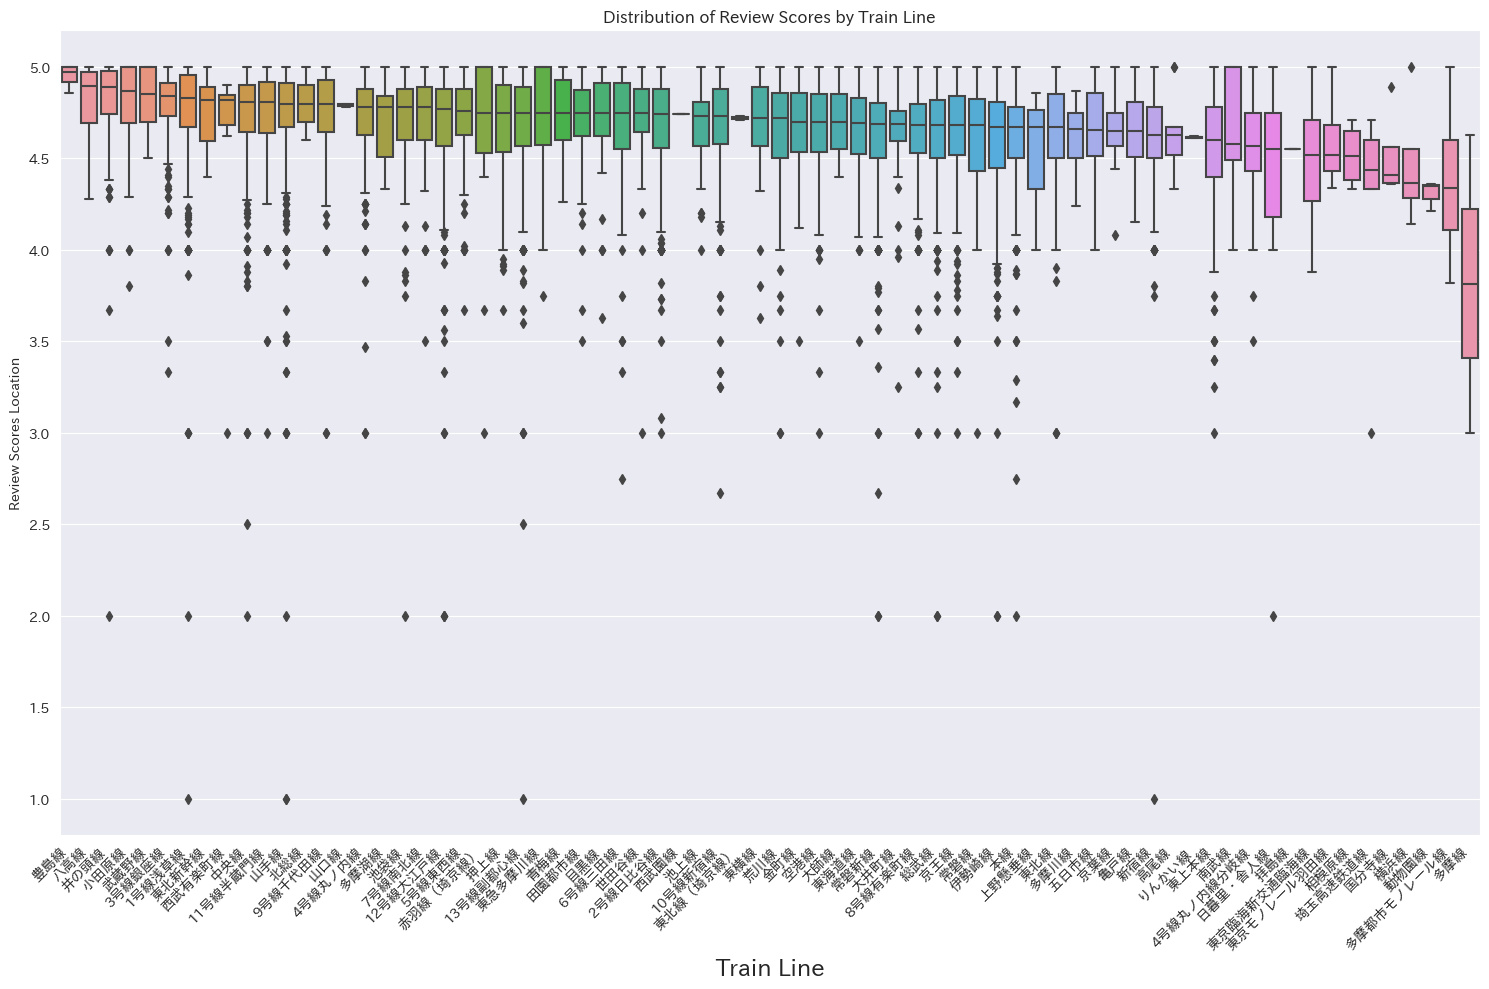

In [53]:
import japanize_matplotlib

plt.figure(figsize=(15, 10))
order = df_full.groupby('train_line').median()['review_scores_location'].sort_values(ascending=False).index
sns.boxplot(data=df_full, x='train_line', y='review_scores_location', order=order)

# Rotate x labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.title('Distribution of Review Scores by Train Line')
plt.xlabel('Train Line', fontsize=17)
plt.ylabel('Review Scores Location')

plt.tight_layout()
plt.show()

## Relation between location and nearest station

I created a boxplot of location review scores for each station. The stations are sorted by the median location review score.

The stations with the highest median location review scores can be classified into two groups:
1. Those close to northern Shinjuku, such as "Okubo", "Shin-Okubo", "Higashi-Shinjuku", "Nishi-Shinjuku-Gochome", "Ikebukuro", "Shimo-Ochiai".
2. Those close to Skytree/Asakusa, such as "Honjo-Azumabashi", "Asakusa", "Oshiage", "Iriya"


/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3684344762.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = filtered_df.groupby('nearest_station').median()['review_scores_location'].sort_values(ascending=not ascending).index


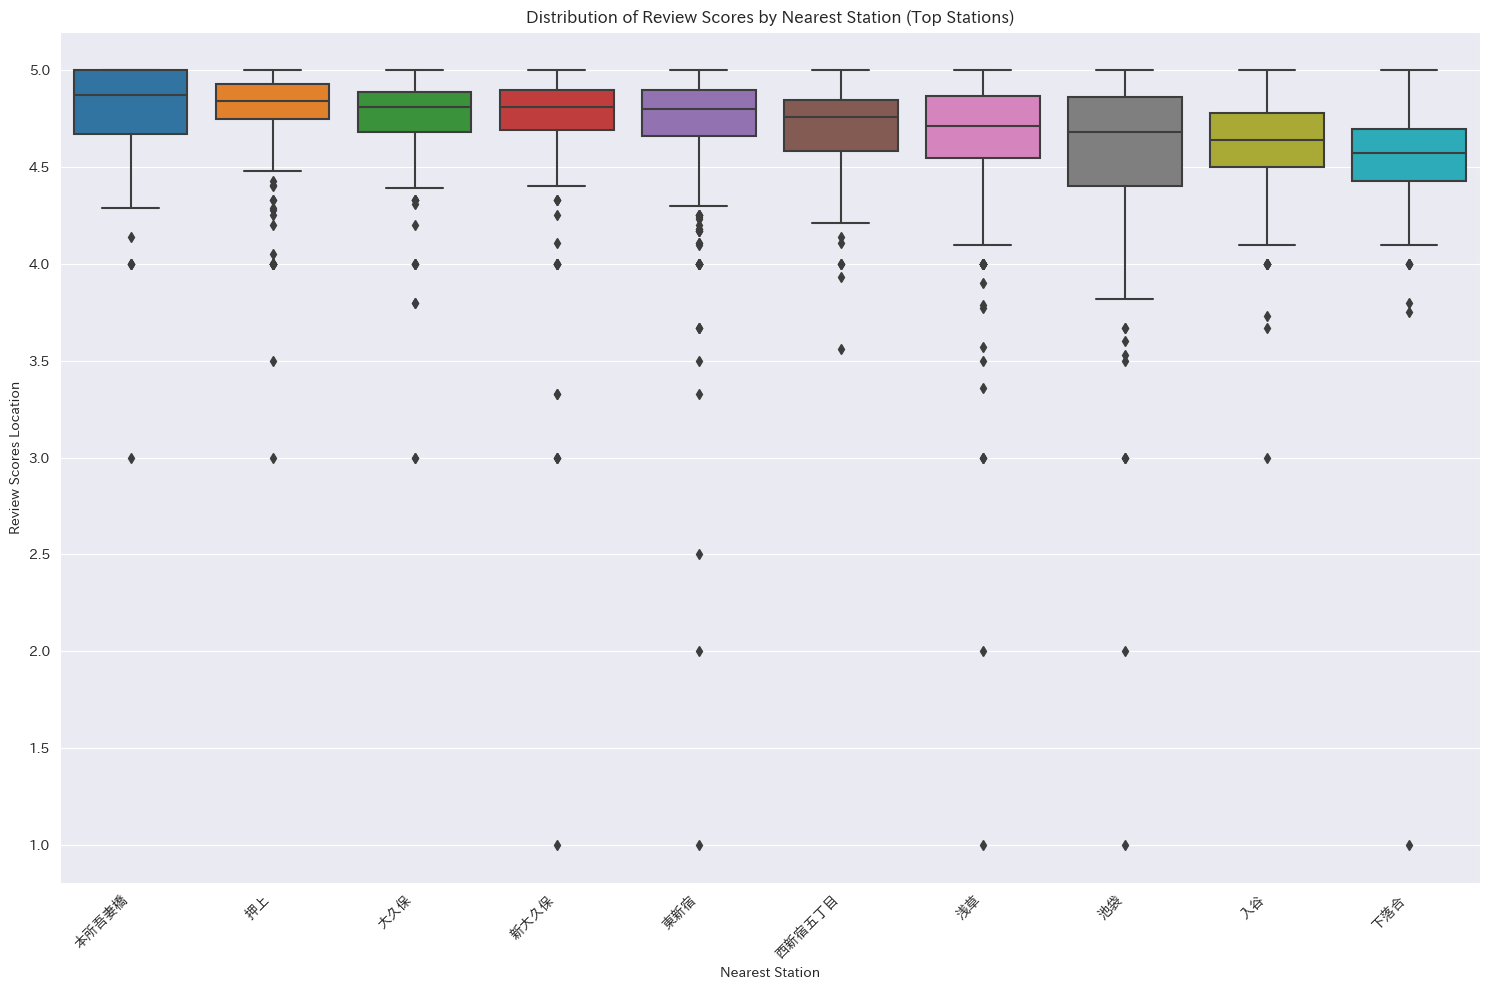

/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3684344762.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = filtered_df.groupby('nearest_station').median()['review_scores_location'].sort_values(ascending=not ascending).index


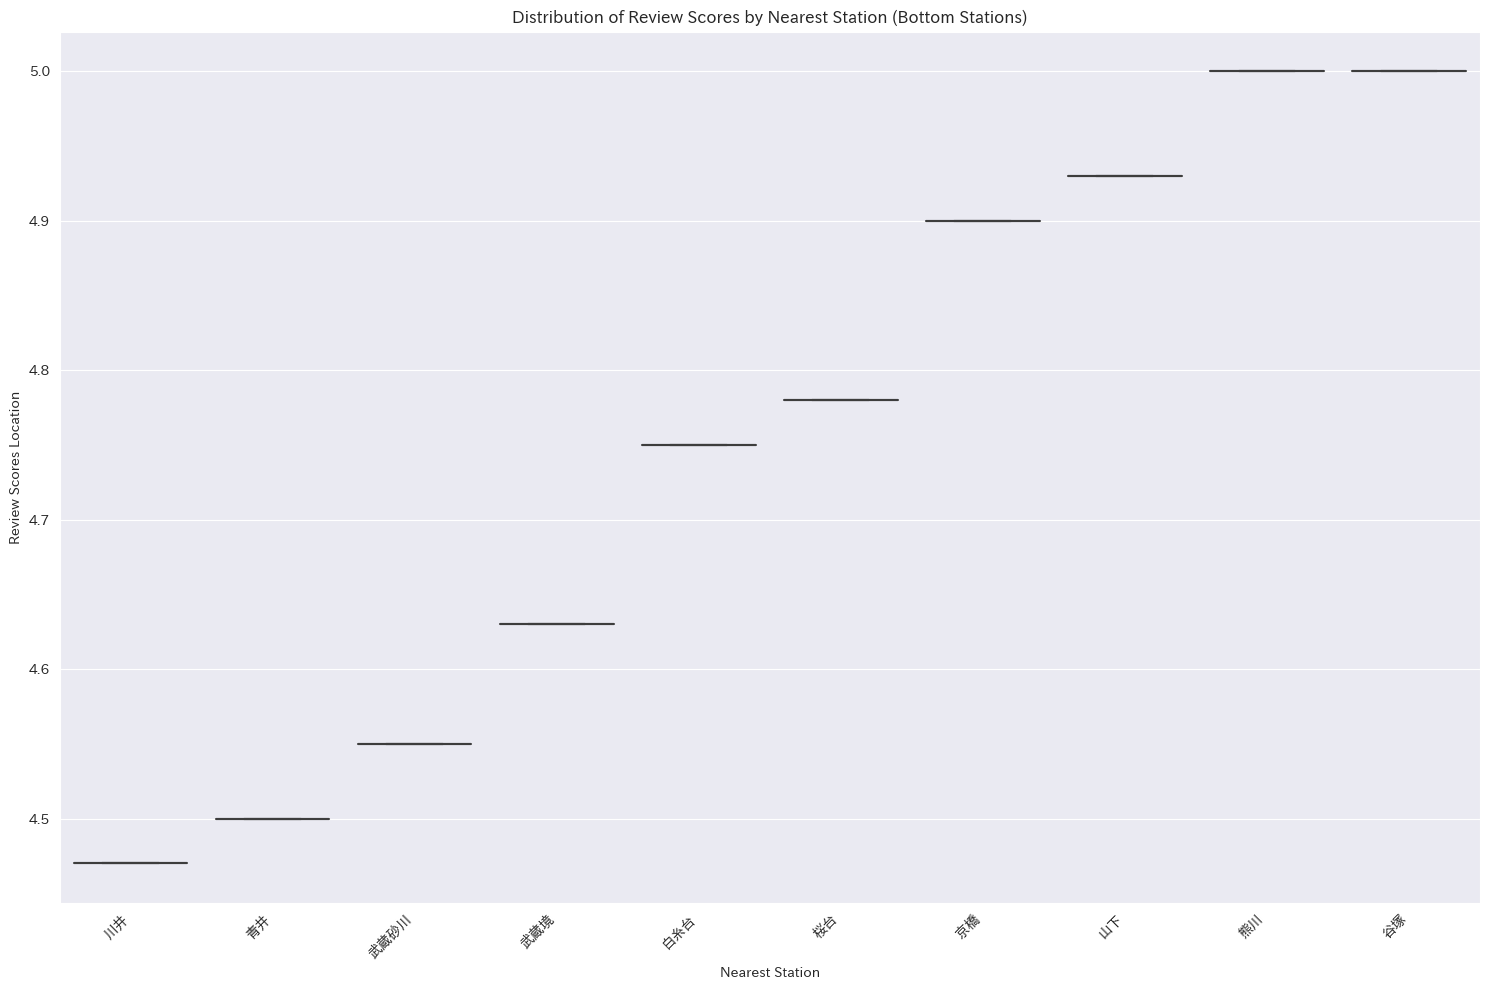

In [67]:
import japanize_matplotlib

def nearest_station_boxplot_by_station(df, ascending=True):
    if ascending:
        top_stations = df['nearest_station'].value_counts().head(10).index
        filtered_df = df[df['nearest_station'].isin(top_stations)]
    else:
        bottom_stations = df['nearest_station'].value_counts().tail(10).index
        filtered_df = df[df['nearest_station'].isin(bottom_stations)]

    plt.figure(figsize=(15, 10))
    order = filtered_df.groupby('nearest_station').median()['review_scores_location'].sort_values(ascending=not ascending).index
    sns.boxplot(data=filtered_df, x='nearest_station', y='review_scores_location', order=order)

    plt.xticks(rotation=45, ha='right')

    label = 'Top' if ascending else 'Bottom'
    plt.title(f'Distribution of Review Scores by Nearest Station ({label} Stations)'.format(label=label))
    plt.xlabel('Nearest Station')
    plt.ylabel('Review Scores Location')

    plt.tight_layout()
    plt.show()

nearest_station_boxplot_by_station(df_full, ascending=True)
nearest_station_boxplot_by_station(df_full, ascending=False)

## Can reviews explain the low location scores in Tokyo?

In [94]:
# Read csv
tokyo_review_df = pd.read_csv("./data/reviews_tokyo_sentiment.csv")
tokyo_review_df = tokyo_review_df[tokyo_review_df.iloc[:, 0].astype(str).str.isnumeric()]
tokyo_review_df.iloc[:, 0] = tokyo_review_df.iloc[:, 0].astype('int64')

df_full = pd.read_csv("./data/listings_tokyo_full.csv")
df_full = df_full[df_full.iloc[:, 0].astype(str).str.isnumeric()]
df_full.iloc[:, 0] = df_full.iloc[:, 0].astype('int64')

df_full_sentiment = pd.merge(df_full, tokyo_review_df, left_on='id_x', right_on='listing_id')

/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3096645039.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tokyo_review_df = pd.read_csv("./data/reviews_tokyo_sentiment.csv")
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3096645039.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tokyo_review_df.iloc[:, 0] = tokyo_review_df.iloc[:, 0].astype('int64')
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3096645039.py:6: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv("./data/listings_tokyo_full.csv")
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_19090/3096645039.py:

I created a scatter plot of location review scores and positive sentiment scores, and calculated the correlation coefficient to see if there is any possibility that reviews can explain why Tokyo has low location review scores.

The correlation coefficient is 0.14, which suggests that there is a fairly weak positive correlation between the two variables. The correlation is not strong enough to suggest that reviews can explain the low location review scores in Tokyo.

Overall, it seems that reviews are not a good indicator of location review scores.

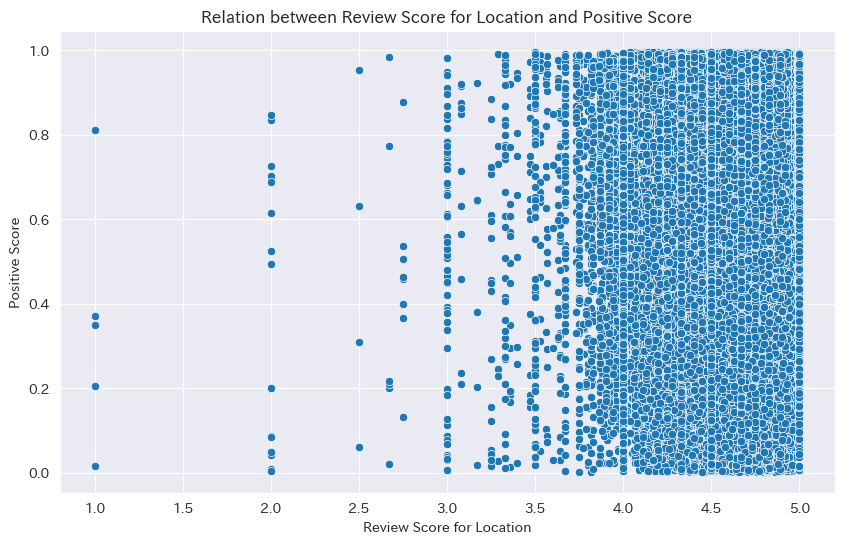

Correlation between review score for location and positive score: 0.14


In [98]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_full_tokyo, x='review_scores_location', y='positive')
plt.title('Relation between Review Score for Location and Positive Score')
plt.xlabel('Review Score for Location')
plt.ylabel('Positive Score')
plt.show()

# Calculate correlation coefficient
correlation = df_full_tokyo['review_scores_location'].corr(df_full_tokyo['positive'])
print(f"Correlation between review score for location and positive score: {correlation:.2f}")

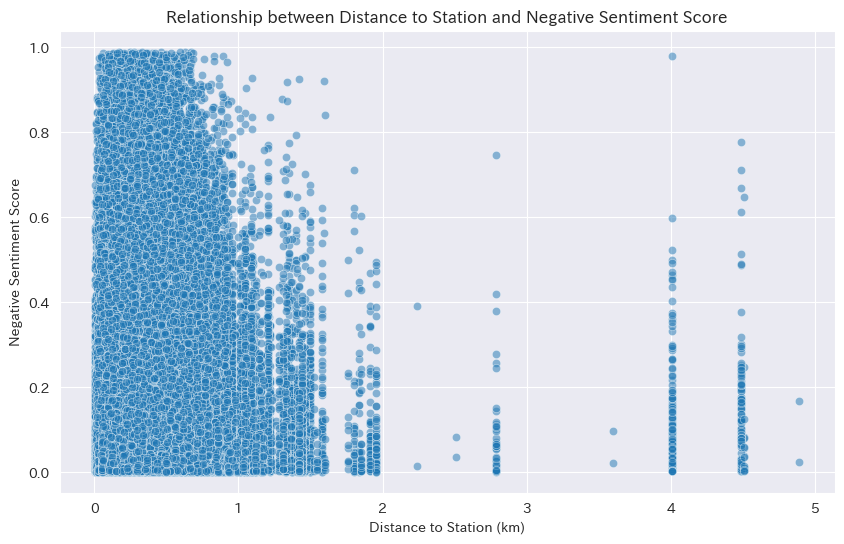

Correlation between distance to station and negative sentiment score: -0.00


In [97]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_full_sentiment, x='distance_to_station', y='negative', alpha=0.5)
plt.title('Relationship between Distance to Station and Negative Sentiment Score')
plt.xlabel('Distance to Station (km)')
plt.ylabel('Negative Sentiment Score')
plt.show()

# Calculate correlation coefficient
correlation = df_full_sentiment['distance_to_station'].corr(df_full_sentiment['negative'])
print(f"Correlation between distance to station and negative sentiment score: {correlation:.2f}")

### Relation between sentiment and language

Now, let's see if there is any difference in sentiment scores between different languages to see if reviews in a certain language are more likely to be negative. If this is the case, then the language of reviews can potentially explain the low location review scores in Tokyo.

In [105]:
# First, analyse language of reviews

from langdetect import detect, LangDetectException

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException: # If the language cannot be detected, return 'unknown'
        return 'unknown'

df_full_sentiment['review_lang'] = df_full_sentiment['comments_y'].apply(lambda x: detect_language(x) if pd.notnull(x) else 'unknown')

KeyboardInterrupt: 

The pie chart shows that the majority of reviews are written in English, followed by Japanese and Simplified Chinese, which is used in 大陸.

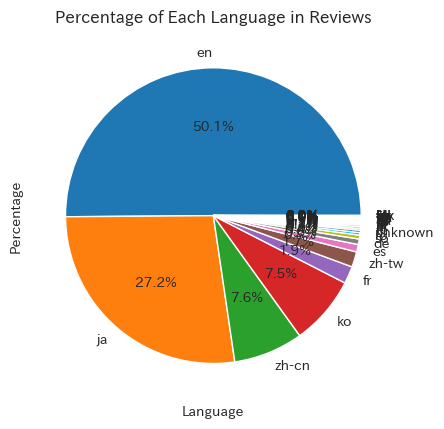

The top 5 languages in reviews are:
en       50.120439
ja       27.202324
zh-cn     7.607122
ko        7.546238
fr        1.892482
Name: review_lang, dtype: float64


In [141]:
# Calculate the percentage of each language
lang_percentage = df_full_sentiment['review_lang'].value_counts(normalize=True) * 100

plt.pie(lang_percentage, labels=lang_percentage.index, autopct='%1.1f%%')
plt.title('Percentage of Each Language in Reviews')
plt.ylabel('Percentage')
plt.xlabel('Language')
plt.show()

print("The top 5 languages in reviews are:")
print(lang_percentage.head(5))

top_5_lang = lang_percentage.head(5).index

### Relation between sentiment and language

Limiting to the languages with the highest percentage, I converted review language to dummy variables, and then calculated the correlation coefficient between each dummy variable and negative sentiment score.

The result shows that while there is a moderate positive relationship between reviews written in Japanese and the negative sentiment score, and relationships between other languages and the negative sentiment score are so weak that there seems no relationship between them.

The correlation coefficient of 0.247654 for Japanese suggests that Japanese people are more likely to write negative reviews than other people.

This result suggests the possibility that **Japanese people are more likely to write negative reviews, which can potentially explain the low location review scores in Tokyo**.

In [142]:
# Calculate the correlation coefficient between negative sentiment score and review language

# Convert review_lang to dummy variables, one-hot encoding
df_dummies = pd.get_dummies(df_full_sentiment['review_lang'])

# Limit the languages that match `top_5_lang`
df_dummies = df_dummies[top_5_lang]

df_dummies['negative_sentiment_score'] = df_full_sentiment['negative']

correlations = df_dummies.corrwith(df_dummies['negative_sentiment_score']).drop('negative_sentiment_score')

print("Correlation between negative sentiment score and review language:")
print(correlations.sort_values(ascending=False).head(10))

# de: German
# fr: French
# th: Thai
# ru: Russian
# sv: Swedish
# tr: Turkish
# it: Italian
# nl: Dutch

Correlation between negative sentiment score and review language:
ja       0.247654
fr       0.035626
ko       0.015857
zh-cn   -0.133576
en      -0.164213
dtype: float64


The positive relation between Japanese and negative sentiment score seems statistically significant, as the box plot shows and p-value is less than 0.05.

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  # Albeit hashmap has O(1) look-up (vs. O(logn) in sorted array),


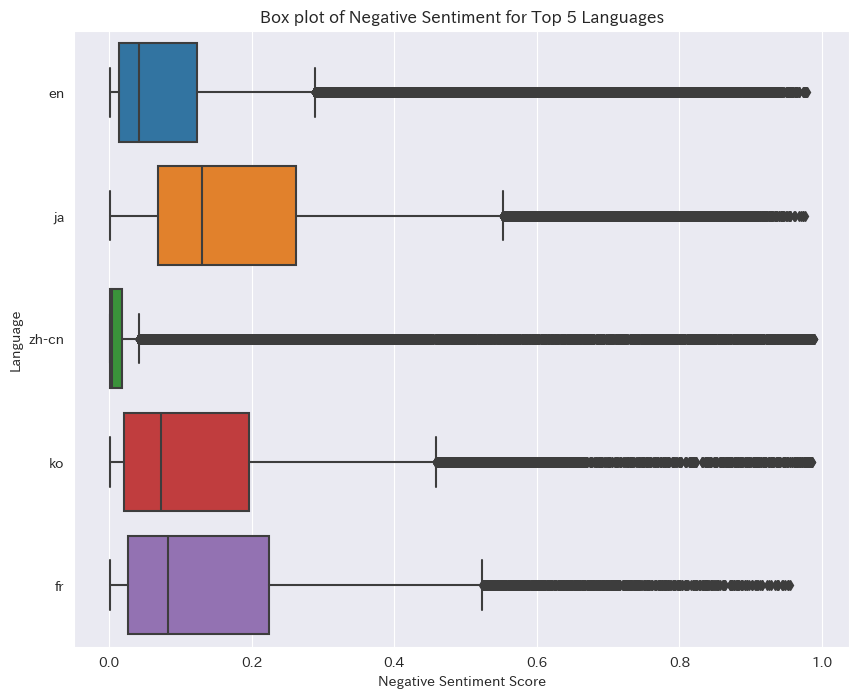

Sample size for each language:
en       226385
ja       122868
zh-cn     34360
ko        34085
fr         8548
Name: review_lang, dtype: int64

Pearson correlation coefficient between being Japanese and negative sentiment: 0.248
The correlation is statistically significant with a p-value of 0.00000


In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Filter data to only include top 5 languages
df_top_languages = df_full_sentiment[df_full_sentiment['review_lang'].isin(top_5_lang)]

# 1. Box plot for top 5 languages
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_top_languages, y='review_lang', x='negative', order=top_5_lang)
plt.title('Box plot of Negative Sentiment for Top 5 Languages')
plt.xlabel('Negative Sentiment Score')
plt.ylabel('Language')
plt.show()

# 2. Display sample size for each language
print("Sample size for each language:")
print(df_top_languages['review_lang'].value_counts())

# 3. Calculate Pearson r for Japanese
# Create a dummy variable for Japanese reviews
df_full_sentiment['is_japanese'] = df_full_sentiment['review_lang'].apply(lambda x: 1 if x == 'ja' else 0)

# Filter out NaN or infinite values in the negative column
df_filtered = df_full_sentiment.dropna(subset=['negative'])
df_filtered = df_filtered[df_filtered['negative'] != float('inf')]
df_filtered = df_filtered[df_filtered['negative'] != float('-inf')]

# Calculate Pearson r
correlation_coefficient, p_value = pearsonr(df_filtered['is_japanese'], df_filtered['negative'])

print(f'\nPearson correlation coefficient between being Japanese and negative sentiment: {correlation_coefficient:.3f}')
if p_value < 0.05:
    print(f'The correlation is statistically significant with a p-value of {p_value:.5f}')
else:
    print(f'The correlation is not statistically significant with a p-value of {p_value:.5f}')



### Review keyword analysis

Let's analyze the keywords in reviews to see if there are any keywords that are associated with low location review scores.

In [109]:
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

languages = ['en', 'ja', 'zh-cn', 'ko', 'fr']
top_tokens_by_language = {}

# Ensure you have the stopwords dataset downloaded
nltk.download('stopwords')

# Define a function to clean the text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Get stopwords for each language
# Stop words are a set of commonly used words in a language. Examples of stop words in English are “a,” “the,” “is,” “are,” etc.
stopwords_by_language = {
    'en': set(stopwords.words('english')),
    'ja': set(),  # Japanese doesn't have stopwords in nltk
    'zh-cn': set(),  # Chinese doesn't have stopwords in nltk
    'ko': set(),  # Korean doesn't have stopwords in nltk
    'fr': set(stopwords.words('french'))
}

def get_top_tokens(texts, lang, num=10):
    all_tokens = []
    for text in texts:
        text = clean_text(text)
        tokens = word_tokenize(text)
        # Remove stopwords
        tokens = [token for token in tokens if token.lower() not in stopwords_by_language[lang]]
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    return counter.most_common(num)

top_tokens_by_language = {}

for lang in languages:
    filtered_reviews = df_full_sentiment[df_full_sentiment['review_lang'] == lang]['comments_y']
    top_tokens = get_top_tokens(filtered_reviews, lang)
    top_tokens_by_language[lang] = top_tokens

for lang, tokens in top_tokens_by_language.items():
    print(f"Top tokens for {lang}: {tokens}\n")

# Translation
# ----- For zh-cn (Chinese Simplified):
#
# 很好: Very good
# 很棒: Great
# 挺好的: Pretty good
# 好: Good
# 房间很干净: The room is very clean
# 很方便: Very convenient
# 很不错: Very nice
# 很干净: Very clean
# 房东人很好: The landlord is very nice
# 还不错: Not bad

# ----- For ko (Korean):
#
# 너무: Too/Very
# 좋았습니다: It was good
# 수: Can (in certain contexts, it's a counter or means "number")
# 잘: Well
# 있어서: Because it exists/is there
# 정말: Really
# 매우: Very
# 숙소: Accommodation
# 깨끗하고: Clean and...
# 조금: A little

# ----- For fr (French):
#
# très: Very
# bien: Good/well
# a: Has (from the verb "avoir")
# logement: Housing/accommodation
# séjour: Stay
# quartier: Neighborhood
# propre: Clean
# Tokyo: Tokyo (same as English)
# situé: Located
# calme: Calm/quiet

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mkurumi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top tokens for en: [('place', 129867), ('stay', 104682), ('great', 72537), ('location', 70567), ('station', 67680), ('clean', 66214), ('Tokyo', 56312), ('host', 48789), ('apartment', 47937), ('room', 44439)]

Top tokens for ja: [('ありがとうございました', 3670), ('よかったです', 1083), ('とても良かったです', 1052), ('良かったです', 639), ('とても綺麗でした', 515), ('とてもよかったです', 499), ('とても快適でした', 374), ('綺麗でした', 350), ('快適に過ごせました', 350), ('快適でした', 335)]

Top tokens for zh-cn: [('很好', 338), ('很棒', 138), ('挺好的', 124), ('好', 124), ('房间很干净', 100), ('很方便', 89), ('很不错', 83), ('很干净', 81), ('房东人很好', 79), ('还不错', 69)]

Top tokens for ko: [('너무', 5487), ('좋았습니다', 4786), ('수', 4662), ('잘', 4633), ('있어서', 3990), ('정말', 3574), ('매우', 3412), ('숙소', 3408), ('깨끗하고', 2724), ('조금', 2705)]

Top tokens for fr: [('très', 8314), ('bien', 4155), ('a', 3169), ('logement', 2725), ('séjour', 1954), ('quartier', 1884), ('propre', 1866), ('Tokyo', 1862), ('situé', 1711), ('calme', 1536)]



## Topic modeling
I made wordcloud for each topic that LDA model identified.
Latent Dirichlet Allocation (LDA) is a probabilistic topic modeling technique that identifies potential topics based on word frequency from a set of documents.

Here are the topics that seemingly have the highest frequency in reviews:
For en:
- Topic 1: Overall experience
- Topic 2: Location
- Topic 3: Accommodation

For ja:
- Topic 1: Overall experience
- Topic 2: Location
- Topic 3: Accommodation, cleanliness

For zh-cn:
- Topic 1: Location, environmental quality
  - The words "便利" (convenient), "环境" (environment), "卫生" (hygiene), "舒适" (comfortable), "安静" (quiet), and "位置" (location) are prominent.
- Topic 2: Customer service
  -  "服务态度" (service attitude), "友好" (friendly), "周到" (thoughtful), "职员" (staff), and "热情" (enthusiastic) stand out.
- Topic 3: Overall experience
  - "不错" (not bad/good), "体验" (experience), "推荐" (recommend), "性价比" (cost performance), and "设施" (facilities)

For ko:
- Topic 1: Accommodation
  -  "청결함" (cleanliness), "친절함" (kindness), "편안함" (comfort), "조식" (breakfast), "위치" (location), and "wifi" (wifi) are prominent.
- Topic 2: Satisfaction
  -  "서비스" (service), "만족합니다" (satisfied), "친절합니다" (kind), "추천합니다" (recommend), "조용합니다" (quiet), and "깨끗합니다" (clean) are prominent.
- Topic 3: Appreciation
  -  "감사합니다" (thank you), "좋았습니다" (was good), "즐거웠습니다" (was enjoyable), "휴식" (rest), "편안한" (comfortable), and "방문" (visit) are prominent.

For fr:
- Topic 1: Overall experience
  - "merci" (thank you), "nous avons" (we have), "très" (very), "bien" (good), "séjour" (stay), "propre" (clean), "hôte" (host), "parfait" (perfect), "recommande" (recommend) are prominent.
- Topic 2: Location, environment
  - "logement" (accommodation), "bien situé" (well located), "calme" (quiet), "propre" (clean), "métro" (metro), "pratique" (practical), "proche" (near/close) are prominent.
- Topic 3: Mix of negative/positive reviews
  -  "Pas" (not) and "plus" (more) could be part of a negative expression like "pas plus" meaning "not anymore" or "no more." Other words like "petit" (small), "mais" (but), "chambre" (bedroom), "cuisine" (kitchen), and "salle de bain" (bathroom) are prominent.

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


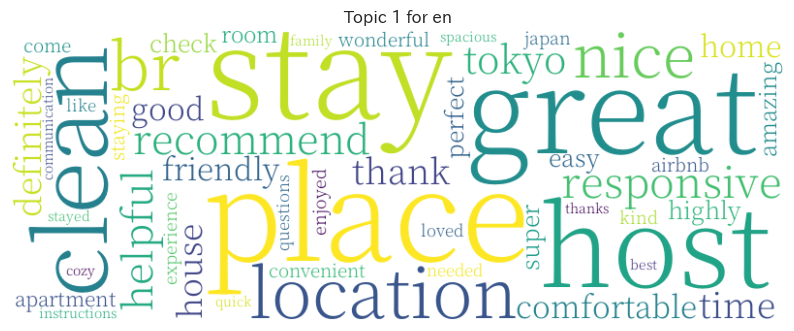

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


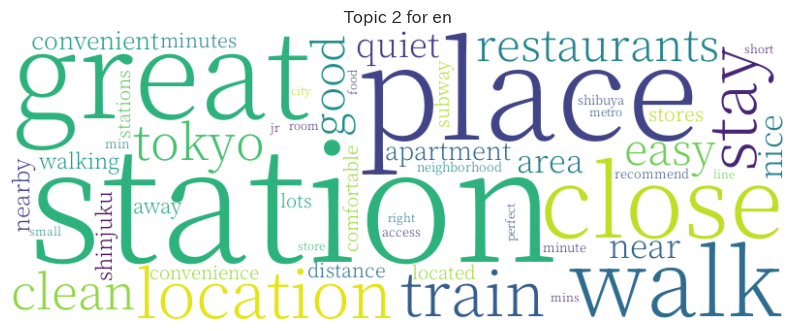

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


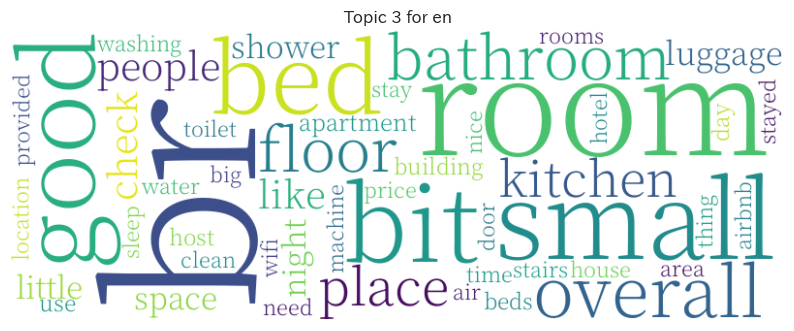

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


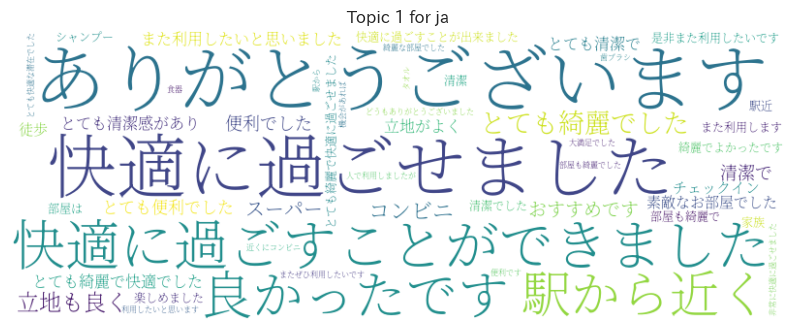

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


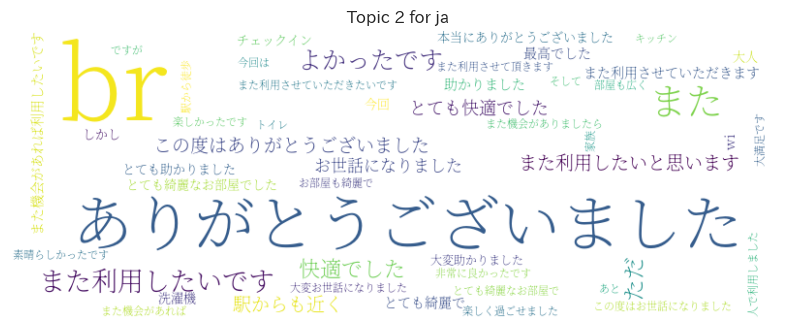

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


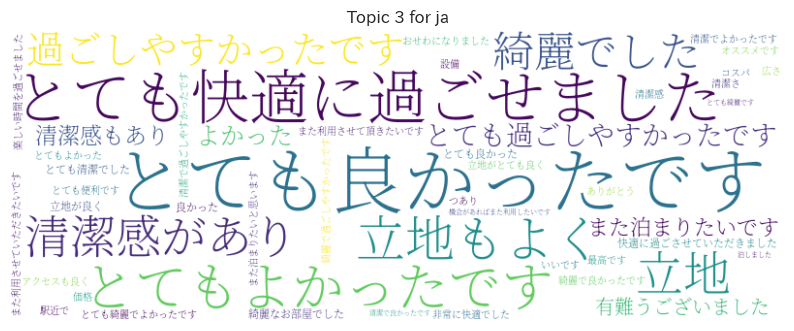

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


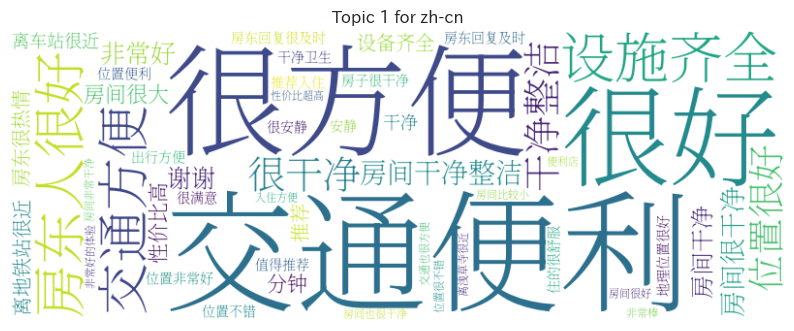

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


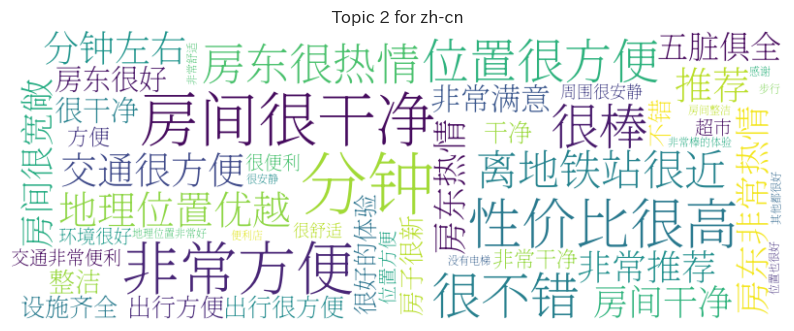

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


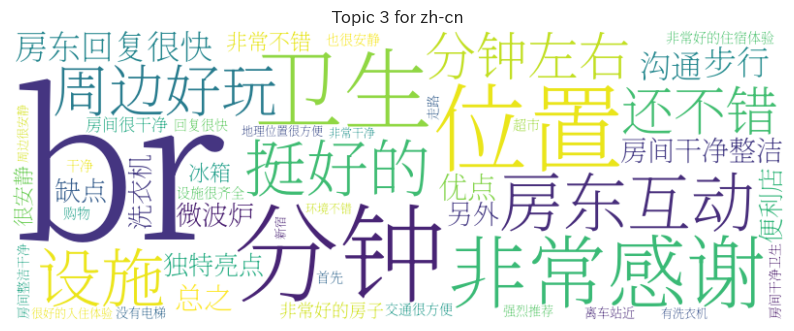

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


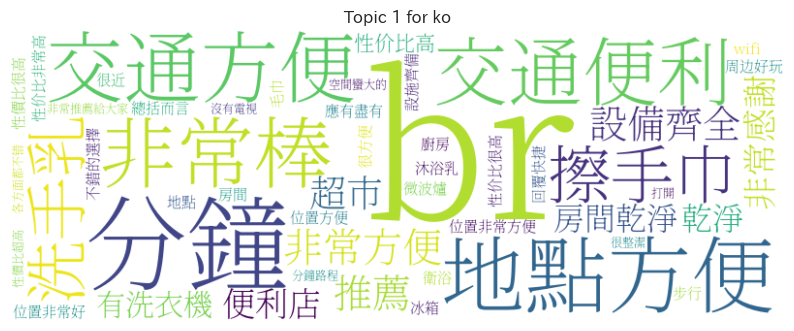

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


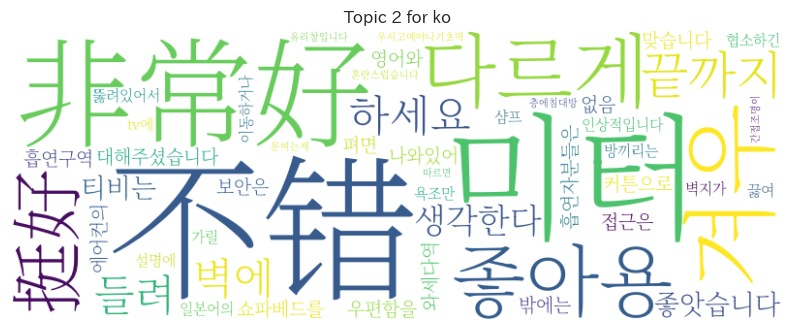

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


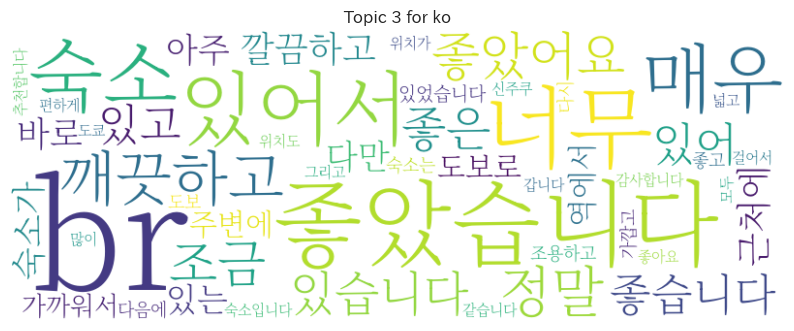

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


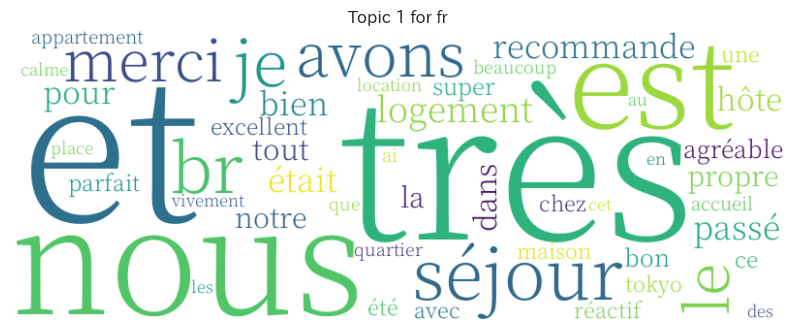

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


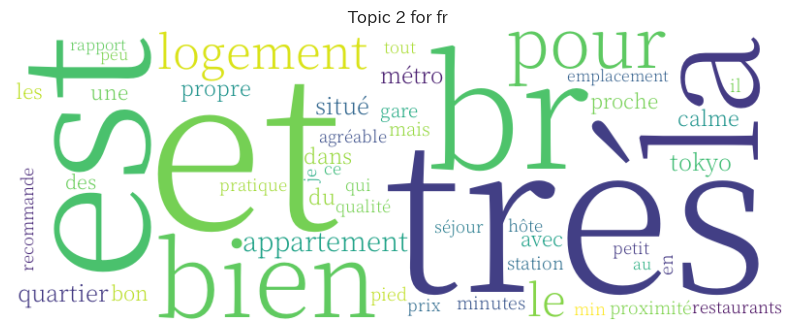

/Users/mkurumi/anaconda3/envs/pythonProject/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


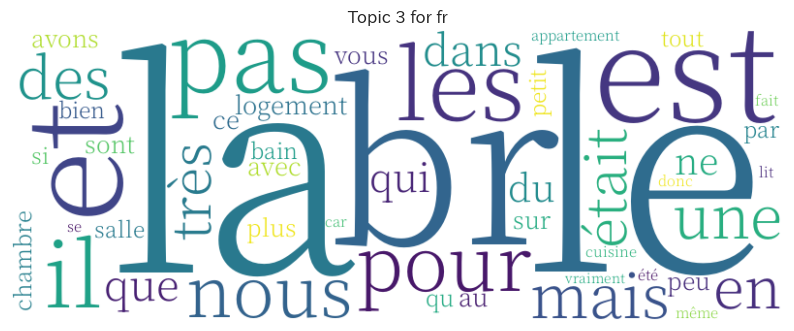

In [132]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud

font_path = './font/NotoSerifCJK-VF.otf.ttc'

# Assuming df_full_sentiment is already loaded
languages = ['en', 'ja', 'zh-cn', 'ko', 'fr']

# Preprocess the text
def preprocess(text):
    return [word for word in gensim.utils.simple_preprocess(text) if word not in gensim.parsing.preprocessing.STOPWORDS]

def plot_word_cloud(lda_model, lang, num_topics):
    for t in range(num_topics):
        plt.figure(figsize=(10, 5))
        topic_terms = lda_model.show_topic(t, topn=50)
        topic_words = dict(topic_terms)
        wc = WordCloud(background_color="white", width=800, height=300, font_path=font_path).generate_from_frequencies(topic_words)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {t + 1} for {lang}")
        plt.show()

# Apply LDA and visualize topics for each language
for lang in languages:
    # Filter reviews by language
    df_lang = df_full_sentiment[df_full_sentiment['review_lang'] == lang]

    # Preprocess reviews
    processed_reviews = df_lang['comments_y'].map(preprocess)

    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(processed_reviews)
    corpus = [dictionary.doc2bow(review) for review in processed_reviews]

    # Apply LDA model
    lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

    # Visualize topics
    plot_word_cloud(lda_model, lang, num_topics=3)